In [1]:
from numpy import *
from scipy import integrate
from scipy.optimize import fsolve
from scipy.signal import hilbert
import pandas as pd
from scipy.signal import argrelextrema
import pylab as p
import matplotlib.pyplot as plt
import math
import seaborn as sns
from functools import wraps
from statistics import covariance
import numdifftools as nd
import sdeint
from scipy.signal import argrelextrema
from random import Random
import os
os.getcwd()
import sys
import time
import matplotlib
import IPython
matplotlib.pyplot.ion()
#%matplotlib widget

In [2]:
#####################
### GRAPHICS ########
#####################
def paramSpace(rowInd,colInd,axs,xdata,Nnum,Anum,Cnum,Dnum,res,ytitle,transp=0.3,lw=1,lnbr=2,color=0):

    #### plot results from parameter loop ####
    numLen=res
    lstyle=['-','--','-.']
    if pr.init[0]>1: lstyle=['','','']
    marks=['.','x','s']
    lcolor=['black','red','blue']
    alphaval=transp
    Xarray=array(split(array(xdata),numLen))
    Narray=array(split(array(Nnum),numLen))
    Aarray=array(split(array(Anum),numLen))
    Carray=array(split(array(Cnum),numLen))
    Darray=array(split(array(Dnum),numLen))

    for k in range(lnbr):
    
        axs[rowInd][colInd+0].plot(Xarray[k,:],Narray[k,:],label=0.5*k,marker=marks[k],linestyle=lstyle[k],linewidth=lw,color=lcolor[color],alpha=transp)
        axs[rowInd][colInd+0].set_title(ytitle[0])

        axs[rowInd][colInd+1].plot(Xarray[k,:],Aarray[k,:],label=0.5*k,marker=marks[k],linestyle=lstyle[k],linewidth=lw,color=lcolor[color],alpha=transp)
        axs[rowInd][colInd+1].set_title(ytitle[1])

        axs[rowInd][colInd+2].plot(Xarray[k,:],Carray[k,:],label=0.5*k,marker=marks[k],linestyle=lstyle[k],linewidth=lw,color=lcolor[color],alpha=transp)
        axs[rowInd][colInd+2].set_title(ytitle[2])

        axs[rowInd][colInd+3].plot(Xarray[k,:],Darray[k,:],label=0.5*k,marker=marks[k],linestyle=lstyle[k],linewidth=lw,color=lcolor[color],alpha=transp)
        axs[rowInd][colInd+3].set_title(ytitle[3])

def make_space_above(axes, topmargin=1):
    # increase figure size to make topmargin (in inches) space for 
    #    titles, without changing the axes sizes
    fig = axes.flatten()[0].figure
    s = fig.subplotpars
    w, h = fig.get_size_inches()

    figh = h - (1-s.top)*h  + topmargin
    fig.subplots_adjust(bottom=s.bottom*h/figh, top=1-topmargin/figh)
    fig.set_figheight(figh)
    

In [3]:
#####################
#### DYNAMICS #######
#####################

def constrain(constraints):
    if all(constraint is not None for constraint in constraints):
         assert constraints[0] < constraints[1]
    def wrap(f):
        @wraps(f)
        def wrapper(t, y, *args, **kwargs):
            lower, upper = constraints
            if lower is None:
                lower = -inf
            if upper is None:
                 upper = inf
                    
            too_low = y <= lower
            too_high = y >= upper

            y = maximum(y, ones(shape(y))*lower)
            y = minimum(y, ones(shape(y))*upper)

            result = f(t, y, *args, **kwargs)

            result[too_low] = maximum(result[too_low], ones(too_low.sum())*lower)
            result[too_high] = minimum(result[too_high], ones(too_high.sum())*upper)
        
            return result

        return wrapper

    return wrap

#### (non)-trophic interactions ######

def fr(ft,res,con,foc,X):   
    if ft==1: return pr.lmda[con]*X[foc]
    elif ft==2: return pr.lmda.at[con]*X[foc]/(pr.resnot.at[res]+X[res])

def habdep(foc,hab,X):
    return 1-((pr.h.at[foc]*X[foc])/(X[foc]+pr.eta.at[foc]*X[hab]))

def eng(engsp,hab,X):
    return ((pr.eg.at[engsp]*X[engsp]+pr.epsi.at[engsp])/(X[engsp]+pr.epsi.at[engsp]))
#def eng(engsp,hab,X):
#    return ((pr.eg[engsp]*X[engsp]+pr.epsi[engsp])/(X[engsp]+pr.epsi[engsp]))

  
@constrain([0, 100])
def dMdf_dt(t,X):  
#### FULL MODEL in matrix form 4 compartments     
    prMult=array([ [-pr.l[0], -fr(pr.frtype[0],0,1,0,X)*habdep(1,3,X), 0, pr.r[0]],
                   [fr(pr.frtype[0],0,1,1,X)*habdep(1,3,X), -pr.m[1], -fr(pr.frtype[0],1,2,1,X)*habdep(2,3,X), 0],
                   [0, fr(pr.frtype[0],1,2,2,X)*habdep(2,3,X), -pr.m[2], 0],
                   [0, pr.delta[0]*pr.m[1], pr.delta[0]*pr.m[2], -pr.r[0]-pr.l[3]*eng(2,3,X)*eng(1,3,X)]])
    prAdd=array([pr.I.at[0],0,0,pr.I.at[3]])
    return dot(prMult,X)+prAdd

def close(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc

def G(x,t):
    #return stddev*sqrt(B)
    return pr.stddev[0]*B

def fdf(x, t):
    prMult=array([ [-pr.l[0], -fr(pr.frtype[0],0,1,0,x)*habdep(1,3,x), 0, pr.r[0]],
                   [fr(pr.frtype[0],0,1,1,x)*habdep(1,3,x), -pr.m[1], -fr(pr.frtype[0],1,2,1,x)*habdep(2,3,x), 0],
                   [0, fr(pr.frtype[0],1,2,2,x)*habdep(2,3,x), -pr.m[2], 0],
                   [0, pr.delta[0]*pr.m[1], pr.delta[0]*pr.m[2], -pr.r[0]-pr.l[3]*eng(2,3,x)*eng(1,3,x)]])
    prAdd=array([pr.I.at[0],0,0,pr.I.at[3]])
    return dot(prMult,x)+prAdd

def jacEq(row,col,NrEq,ArEq,CrEq,DrEq):
    
    fun= lambda X: dot(array([[-pr.l[0], -fr(pr.frtype[0],0,1,0,X)*habdep(1,3,X), 0, pr.r[0]],
                   [fr(pr.frtype[0],0,1,1,X)*habdep(1,3,X), -pr.m[1], -fr(pr.frtype[0],1,2,1,X)*habdep(2,3,X), 0],
                   [0, fr(pr.frtype[0],1,2,2,X)*habdep(2,3,X), -pr.m[2], 0],
                   [0, pr.delta[0]*pr.m[1], pr.delta[0]*pr.m[2], -pr.r[0]-pr.l[3]*eng(2,3,X)*eng(1,3,X)]])
                       +array([pr.I.at[0],0,0,pr.I.at[3]]),X)+array([pr.I.at[0],0,0,pr.I.at[3]])    
    jac = nd.Jacobian(fun)([NrEq,ArEq,CrEq,DrEq])
    return jac[row][col]

def minmax(xseries): 
    df = pd.DataFrame(xseries, columns=['data'])
    n = 2  # number of points to be checked before and after
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df.data.values, less_equal,
                        order=n)[0]]['data']
    df['max'] = df.iloc[argrelextrema(df.data.values, greater_equal,
                        order=n)[0]]['data']   
    return min(df['min'].dropna()),max(df['max'].dropna())

In [4]:
#####################
####PARAMETERS#######
#####################
def params(save=0,read=0,fname='receng_params.csv'):
    #Defintion of state variables and parameters
    #X[0]: nutrient N
    #X[1]: autotroph A
    #X[2]: herbivore/consumer C
    #X[3]: detritus D
    directory = './params/'
    if read==1: paramObj=pd.read_csv(os.path.join(directory,fname))
    else:
        # recycling
        r = 1         # detritus recycling rate
        delta = 1   # herbivore and autotroph recycling efficiency 
        dr=[0,0,0,0] # direct recycling
        # Growth and mortality
        lmda=[0,2,1,0]
        m=[0,0.1,0.1,0]
        resnot=[0.1,0.5,0,0] #half-saturation
        # Subsidies and outputs
        I=[0.05,0,0,0.05]
        l=[0.1,0,0,2]
        # habitat dependence
        h=[0,1,0,0] # habitat dependence
        eta=[0,0.6,0.6,0] # value of detritus as habitat 
        # engineering
        eg=[1,1,0.1,1]  #engineering intensity (1 -> no engineering)
        epsi=[0,0.75,0.75,0] # half-saturation of engineering effect
        # options for simulations
        pert=0
        init=1
        jac=0
        stoch=1
        fCol=0
        resS=2 # number of series
        resL=12 # number of X values 
        Iadj=0
        lmdaAdj=1
        stddev=0.01
        frtype=2
        scenario=['none', 'none']
        varName=['eta','eg'] # x axis variable and series variable 
        xVal=[0.1,1.9] # range of values of the x axis variable
        serVal=[1,0.1] # list of values of the series variable for each series
        indx=[1,2] # index of species invovled in parameter space along x axis and across series

        paramObj=pd.DataFrame({'r':pd.Series(r),'delta':pd.Series(delta),'dr':pd.Series(dr),'lmda':pd.Series(lmda),'m':pd.Series(m),'I':pd.Series(I),
                               'l':pd.Series(l),'h':pd.Series(h),'eta':pd.Series(eta),'eg':pd.Series(eg),'epsi':pd.Series(epsi),'resnot':pd.Series(resnot),
                               'stoch':pd.Series(stoch),'stddev':pd.Series(stddev),'scenario':pd.Series(scenario),'frtype':pd.Series(frtype),'resL':pd.Series(resL),
                               'resS':pd.Series(resS),'Iadj':pd.Series(Iadj),'jac':pd.Series(jac),'pert':pd.Series(pert),'init':pd.Series(init),
                               'varName':pd.Series(varName),'xVal':pd.Series(xVal),'serVal':pd.Series(serVal),'indx':pd.Series(indx)})        
        if save==1:
            timestr = time.strftime("%Y%m%d-%H%M%S")
            filename=''.join([fname,timestr,'.csv'])
            paramObj.to_csv(os.path.join(directory,filename))
   
    return paramObj 

def setParams(fromFile=1,fnbr=0):
    if fromFile==1: prSim=params(read=1,fname=pfiles['name'][fnbr])
    else: prSim=params()
    return prSim

def genParams(val=[],pspace=[],fromfile=1,filen='paramfile',append=0):
    directory = './params/'
    if append==1: pfiles=pd.read_csv(os.path.join(directory,'receng_parspace.csv'))
    else: pfiles=pd.DataFrame()
    par=params(save=0,read=fromfile,fname=filen)
    print(len(val),len(pspace))
    for i in range(len(val)):
        for j in range(len(pspace)) :
            if len(pspace)==1: par[pspace[j]]=val[i]
            else: par[pspace[j]]=val[i][j]
        timestr = time.strftime("%Y%m%d-%H%M%S")
        filename=''.join(['receng_params',timestr,str(i),'.csv'])        
        file_path = os.path.join(directory,filename)
        par.to_csv(file_path)
        fdf=pd.DataFrame({'name':pd.Series(filename)})
        pfiles=pd.concat([pfiles,fdf], ignore_index=True)
    if append==0: open('receng_parspace.csv','w')
    pfiles.to_csv('receng_parspace.csv')
    

In [5]:
#genParams(val=[[[0,2,1,0],[0.1,0,0,2]],[[0,3,1,0],[0.1,0,0,2]],[[0,2,1,0],[0.1,0,0,3]],[[0,3,1,0],[0.1,0,0,3]]],pspace=['lmda','l'],append=0)
#genParams(val=[[[0,2,1,0],[0.1,0,0,2]],[[0,5,1,0],[0.1,0,0,2]],[[0,2,1,0],[0.1,0,0,5]],[[0,5,1,0],[0.1,0,0,5]]],pspace=['lmda','l'],append=0)
#genParams(val=[[0,0,0,0],[0.1,0.1,0.1,0.1],[0.5,0.5,0.5,0.5],[1,1,1,1]],fromfile=1,pspace=['r'],filen='recengAutType2.csv')
#genParams(val=[[[0,0,0,0],[0,0,0,0]],[[0,0,0,0],[1,1,1,1]],[[1,1,1,1],[0,0,0,0]],[[1,1,1,1],[1,1,1,1]]],fromfile=1,pspace=['r','delta'],filen='recengAutType2.csv')
#genParams(val=[[[0,0,0,0],[0.05,0,0,0.05]],[[0,0,0,0],[0.1,0,0,0.05]],[[1,1,1,1],[0.05,0,0,0.05]],[[1,1,1,1],[0.1,0,0,0.05]]],fromfile=1,pspace=['r','I'],filen='recengAutType2.csv')
#genParams(val=[[0.1,0.9,0,0],[0.3,0.6,0,0],[0.5,0.5,0,0],[0.6,0.3,0,0],[0.1,0.5,0,0],[0.5,0.1,0,0]],fromfile=1,pspace=['resnot'],filen='recengAutType2.csv')
#genParams(val=[[0.05,0,0,0.05],[0.1,0,0,0.01],[0.5,0,0,0.05]],fromfile=1,pspace=['I'],filen='recengAutType1.csv')
#genParams(val=[[0.01,0,0,0.05],[0.05,0,0,0.05],[0.1,0,0,0.05],[0.2,0,0,0.05]],fromfile=1,pspace=['l'],filen='recengAutType1.csv')
#genParams(val=[[[0.01,0,0,0.01],[0.01,0,0,1]],[[0.05,0,0,0.01],[0.01,0,0,1]],[[0.01,0,0,0.01],[0.01,0,0,0.5]],[[0.05,0,0,0.01],[0.01,0,0,0.5]]],fromfile=1,pspace=['I','l'],filen='recengAutType1.csv')
genParams(val=[[0,0,0,0]],fromfile=1,pspace=['dr'],filen='recengAutType2.csv')

#genParams(val=[[0.6,0.3,0,0],[0.6,0.1,0,0]],fromfile=1,pspace=['resnot'],filen='recengAutType2.csv')
#params(read=0,save=1,fname='recengConsType2.csv')

1 1


In [6]:
lmdaGrad=linspace(0.1,1,50)
CAnal=(pr.I[0]*pr.lmda[1]*lmdaGrad-pr.lmda[1]*pr.m[1]*pr.m[2]-lmdaGrad*pr.l[0]*pr.m[1])/(lmdaGrad*(pr.lmda[1]*pr.m[2]+lmdaGrad*pr.l[0]))
#CAnal=(0.1*1*lmdaGrad-1*0.1*0.1-lmdaGrad*0.1*0.1)/(lmdaGrad*(1*0.1+lmdaGrad*0.1))
plt.plot(lmdaGrad,CAnal)

lmdacMin=(pr.lmda[1]*pr.m[1]*pr.m[2])/(pr.I[0]*pr.lmda[1]-pr.l[0]*pr.m[1]) # min lmdac for C persistence
lmdacMax=(pr.lmda[1]*pr.l[0]*pr.m[1]*pr.m[2]+pr.m[2]*sqrt(pr.I[0]*pow(pr.lmda[1],3)*pr.l[0]*pr.m[1]))/(pr.I[0]*pr.lmda[1]*pr.l[0]-pow(pr.l[0],2)*pr.m[1]) # lmdac of max C
display(lmdacMax,lmdacMin)

NameError: name 'pr' is not defined

In [7]:
############################
##### MAIN SCRIPT ##########
############################

pfiles=pd.read_csv('receng_parspace.csv')
print(pfiles)

for k in range(len(pfiles['name'])):
    
    pr=setParams(fromFile=1,fnbr=k)
    with pd.option_context('display.width', 160,'display.max_rows', None,'display.max_columns', None,'display.precision', 3,):
                    display(pr)
    lmdacMax=(pr.lmda[1]*pr.l[0]*pr.m[1]*pr.m[2]+pr.m[2]*sqrt(pr.I[0]*pow(pr.lmda[1],3)*pr.l[0]*pr.m[1]))/(pr.I[0]*pr.lmda[1]*pr.l[0]-pow(pr.l[0],2)*pr.m[1]) # lmdac of max C
    print('lmdac of max C*:',lmdacMax) 
    
    preNnum=[];preAnum=[]; preCnum=[];preDnum=[]
    ctrN=[];ctrA=[];ctrC=[];ctrD=[]
    lmdaaAdj=[];lmdacAdj=[];ldAdj=[]
    xaxis=[] 
    minCtrN=[];minCtrA=[];minCtrC=[];minCtrD=[];
    maxCtrN=[];maxCtrA=[];maxCtrC=[];maxCtrD=[];
    minAdjN=[];minAdjA=[];minAdjC=[];minAdjD=[];
    maxAdjN=[];maxAdjA=[];maxAdjC=[];maxAdjD=[];   
    NpertN=[];NpertA=[]; NpertC=[];NpertD=[]
    ApertN=[];ApertA=[]; ApertC=[];ApertD=[]
    CpertN=[];CpertA=[]; CpertC=[];CpertD=[]
    DpertN=[];DpertA=[]; DpertC=[];DpertD=[]
    RecEff=[];Aprod=[];Cprod=[];CprodTroph=[];Dlim=[];Dfac=[];Aeng=[];haArray=[];hcArray=[];etaaArray=[];etacArray=[]
    jac_fCdD=[]
    jacAll=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    CovCD=[];CovCN=[];CovCA=[];CovDN=[];CovDA=[];CovDC=[];CovNA=[]
    VarN=[];VarA=[];VarC=[];VarD=[]
    CovCDctr=[];CovCNctr=[];CovCActr=[];CovDNctr=[];CovDActr=[];CovDCctr=[];CovNActr=[]
    VarNctr=[];VarActr=[];VarCctr=[];VarDctr=[];
    MeanNctr=[];MeanActr=[];MeanCctr=[];MeanDctr=[];
    MeanNadj=[];MeanAadj=[];MeanCadj=[];MeanDadj=[];

    for i in range(int(pr.resS[0])):
        for j in linspace(pr['xVal'][0],pr['xVal'][1],int(pr.resL[0])):
            pr=setParams(fromFile=1,fnbr=k)
            if pr.Iadj[0]==1:
                pr.at[pr['indx'][0],pr['varName'][0]]=j  
                pr.at[pr['indx'][1],pr['varName'][1]]=pr['serVal'][i]
                deltaOld=pr.delta.at[0]
                rOld=pr.r.at[0]
                pr['delta']=[1,1,1,1]
                pr['r']=[0,0,0,1]
                t = linspace(0,10000,50000)                               
                X0=array([random.uniform(0.1,2),random.uniform(0.1,2),random.uniform(0.1,2),random.uniform(0.1,2)]) 
                X = integrate.solve_ivp(dMdf_dt, [t[0], t[-1]], X0,t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                tr=X.t
                #InAdj=In+(1-deltaOld)*r*Dr[-1]
                adjID=pr.I.at[3]+(1-deltaOld)*(pr.m.at[1]*Ar[-1]+pr.m.at[2]*Cr[-1])
                adjIN=pr.I.at[0]+(1-rOld)*Dr[-1] 
                print('adjIN=',adjIN,'adjID=',adjID,'\n')

            ### Generate non adjusted time series #####
            t = linspace(0,10000,50000)                    
            for ic in range(int(pr.init[0])):
                pr=setParams(fromFile=1,fnbr=k)
                #if pr.Iadj[0]==1: pr.I=[adjIN,0,0,adjID]
                if pr.Iadj[0]==1: pr.I=[adjIN,0,0,adjID]
                pr.at[pr['indx'][0],pr['varName'][0]]=j  
                pr.at[pr['indx'][1],pr['varName'][1]]=pr['serVal'][i]
                print('original parameters: lmdaa=',pr.lmda[1],'lmdac=',pr.lmda[2],'lD=',pr.l[3],'ha=',pr.h[1],'hc=',pr.h[2],'ea=',pr.eg[1],'ec=',pr.eg[2])
                X0=array([random.uniform(0.1,2),random.uniform(0.1,2),random.uniform(0.1,2),random.uniform(0.1,2)])
                #X0 = array([0.1,0.1,0.1,0.1]) 
                X = integrate.solve_ivp(dMdf_dt, [t[0], t[-1]], X0,t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                #X = integrate.solve_ivp(dMdf_dt, [t[0], t[-1]], X0,t_eval=t,dense_output=True)
                Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                tr=X.t
                trans=int(len(Nr)/4)
                minN,maxN=minmax(Nr[-10000:-1])
                minCtrN.append(minN),maxCtrN.append(maxN)
                minA,maxA=minmax(Ar[-10000:-1])
                minCtrA.append(minA),maxCtrA.append(maxA)
                minC,maxC=minmax(Cr[-10000:-1])
                minCtrC.append(minC),maxCtrC.append(maxC)
                minD,maxD=minmax(Dr[-10000:-1])
                minCtrD.append(minD),maxCtrD.append(maxD)
                xaxis.append(pr[pr['varName'][0]][pr.indx[0]])
                ctrN.append(mean(Nr[trans:]))
                ctrA.append(mean(Ar[trans:]))
                ctrC.append(mean(Cr[trans:]))
                ctrD.append(mean(Dr[trans:]))
    
                Nctr=mean(Nr[trans:]);Actr=mean(Ar[trans:]);Cctr=mean(Cr[trans:]);Dctr=mean(Dr[trans:])

                if pr.jac[0]==1:
                    for m in [0,1,2,3]:
                        for n in [0,1,2,3]:
                            jacAll[4*m+n].append(jacEq(m,n,Nctr,Actr,Cctr,Dctr))   

                if pr.stoch[0]==1:
                ### stochastic dynamics on non-adjusted equilibria   
                    tspan = linspace(0.0, 10000.0, 100001)
                    B = diag([Nctr,Actr,Cctr,Dctr]) # Noise; diagonal, so independent driving Wiener processes
                    B[0,0]=0;B[1,1]=0;B[2,2]=0  # effect of perturbation in subset of compartments
                    x0=array([Nctr,Actr,Cctr,Dctr])
                    sde = sdeint.itoint(fdf, G, x0, tspan)
                    trans=int(len(tspan)/4)
                    sdestn=sde[trans:,0:]
                    sdecov=cov(transpose(sdestn))
                    sdemean=mean(sdestn,axis=0)
                    MeanNctr.append(sdemean[0])
                    MeanActr.append(sdemean[1])
                    MeanCctr.append(sdemean[2])
                    print('MeanCctr= ',sdemean[2],'e_A= ',pr.eg[1])
                    MeanDctr.append(sdemean[3])
                    CovCDctr.append(sdecov[3,2])
                    CovDCctr.append(sdecov[2,3])            
                    CovCNctr.append(sdecov[0,2])
                    CovCActr.append(sdecov[1,2])
                    CovDNctr.append(sdecov[0,3])
                    CovDActr.append(sdecov[1,3])
                    CovNActr.append(sdecov[0,1])
                    VarNctr.append(sdecov[0,0])
                    VarActr.append(sdecov[1,1])
                    VarCctr.append(sdecov[2,2])
                    VarDctr.append(sdecov[3,3])


                ## adjusting values of lmda and ld and switching off ea and hc           
                pr.lmda=[0,pr.lmda[1]*(1-((pr.h[1]*Actr)/(Actr+pr.eta[1]*Dctr))),pr.lmda[2]*(1-((pr.h[2]*Cctr)/(Cctr+pr.eta[2]*Dctr))),0]
                pr.l=[pr.l[0],0,0,pr.l[3]*((pr.eg[1]*Actr+pr.epsi[1])/(Actr+pr.epsi[1]))*((pr.eg[2]*Cctr+pr.epsi[2])/(Cctr+pr.epsi[2]))]
                lmdaaAdj.append(pr.lmda[1])
                lmdacAdj.append(pr.lmda[2])
                hcArray.append(pr.h[2])
                haArray.append(pr.h[1])
                etacArray.append(pr.eta[2])
                etaaArray.append(pr.eta[1])
                ldAdj.append(pr.l[3])
                pr.eg=[1,1,1,1]
                pr.h=[0,0,0,0]
                print('adjusted parameters: lmdaa=',pr.lmda[1],'lmdac=',pr.lmda[2],'lD=',pr.l[3],'ha=',pr.h[1],'hc=',pr.h[2],'ea=',pr.eg[1],'ec=',pr.eg[2])

                ### dynamics on adjusted parameters ####                        
                X = integrate.solve_ivp(dMdf_dt, [t[0], t[-1]], X0,t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                #X = integrate.solve_ivp(dMdf_dt, [t[0], t[-1]], X0,t_eval=t,dense_output=True)
                Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                tr=X.t
                trans=int(len(Nr)/4)
                minN,maxN=minmax(Nr[-10000:-1])
                minAdjN.append(minN),maxAdjN.append(maxN)
                minA,maxA=minmax(Ar[-10000:-1])
                minAdjA.append(minA),maxAdjA.append(maxA)
                minC,maxC=minmax(Cr[-10000:-1])
                minAdjC.append(minC),maxAdjC.append(maxC)
                minD,maxD=minmax(Dr[-10000:-1])
                minAdjD.append(minD),maxAdjD.append(maxD) 
                preNnum.append(mean(Nr[trans:]))
                preAnum.append(mean(Ar[trans:]))
                preCnum.append(mean(Cr[trans:]))
                preDnum.append(mean(Dr[trans:]))

                NrEq=mean(Nr[trans:]);ArEq=mean(Ar[trans:]);CrEq=mean(Cr[trans:]);DrEq=mean(Dr[trans:])


                if pr.stoch[0]==1:
                ## on adjusted parameters
                    tspan = linspace(0.0, 10000.0, 100001)
                    B = diag([NrEq,ArEq,CrEq,DrEq]) # Noise; diagonal, so independent driving Wiener processes
                    B[0,0]=0;B[1,1]=0;B[2,2]=0  # effect of perturbation in subset of compartments
                    x0=array([NrEq,ArEq,CrEq,DrEq])
                    args=pr.to_dict('series')
                    sde = sdeint.itoint(fdf, G, x0, tspan)
                    trans=int(len(tspan)/4)
                    sdestn=sde[trans:,0:]
                    sdemean=mean(sdestn,axis=0)
                    MeanNadj.append(sdemean[0])
                    MeanAadj.append(sdemean[1])
                    MeanCadj.append(sdemean[2])
                    MeanDadj.append(sdemean[3])
                    sdecov=cov(transpose(sdestn))
                    CovCD.append(sdecov[3,2])
                    CovDC.append(sdecov[2,3])            
                    CovCN.append(sdecov[0,2])
                    CovCA.append(sdecov[2,1])
                    CovDN.append(sdecov[0,3])
                    CovDA.append(sdecov[1,3])
                    CovNA.append(sdecov[1,0])
                    VarN.append(sdecov[0,0])
                    VarA.append(sdecov[1,1])
                    VarC.append(sdecov[2,2])
                    VarD.append(sdecov[3,3])

                if pr.pert[0]==1:                    ### short-term Perturbation Analysis

                    t=linspace(0,0.1,100)     
                    ### df(X)/dN
                    X = integrate.solve_ivp(dX_dt, [0, 0.1],
                                            [NrEq*(1+stddev), ArEq, CrEq, DrEq],
                                            t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                    Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                    tr=X.t
                    NpertN.append((log(Nr[-1])-log(Nr[0]))/t[-1])
                    NpertA.append((log(Ar[-1])-log(Ar[0]))/t[-1])
                    NpertC.append((log(Cr[-1])-log(Cr[0]))/t[-1])
                    NpertD.append((log(Dr[-1])-log(Dr[0]))/t[-1])

                    ### df(X)/dA
                    X = integrate.solve_ivp(dX_dt, [0, 0.1],
                                            [NrEq, ArEq*(1+stddev), CrEq, DrEq],
                                            t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                    Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                    tr=X.t
                    ApertN.append((log(Nr[-1])-log(Nr[0]))/t[-1])
                    ApertA.append((log(Ar[-1])-log(Ar[0]))/t[-1])
                    ApertC.append((log(Cr[-1])-log(Cr[0]))/t[-1])
                    ApertD.append((log(Dr[-1])-log(Dr[0]))/t[-1]) 

                    ### df(X)/dC
                    X = integrate.solve_ivp(dX_dt, [0, 0.1],
                                            [NrEq, ArEq, CrEq*(1+stddev), DrEq],
                                            t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                    Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                    tr=X.t
                    CpertN.append((log(Nr[-1])-log(Nr[0]))/t[-1])
                    CpertA.append((log(Ar[-1])-log(Ar[0]))/t[-1])
                    CpertC.append((log(Cr[-1])-log(Cr[0]))/t[-1])
                    CpertD.append((log(Dr[-1])-log(Dr[0]))/t[-1]) 

                    ### df(X)/dD
                    X = integrate.solve_ivp(dX_dt, [0, 0.1],
                                            [NrEq, ArEq, CrEq, (1+stddev)*DrEq],
                                            t_eval=t,dense_output=True,atol=1e-9, rtol=1e-9)
                    Nr,Ar,Cr,Dr=X.y[0],X.y[1],X.y[2],X.y[3]
                    tr=X.t
                    DpertN.append((log(Nr[-1])-log(Nr[0]))/t[-1])
                    DpertA.append((log(Ar[-1])-log(Ar[0]))/t[-1])
                    DpertC.append((log(Cr[-1])-log(Cr[0]))/t[-1])
                    DpertD.append((log(Dr[-1])-log(Dr[0]))/t[-1])

   Unnamed: 0                               name
0           0  receng_params20230608-1341280.csv


,Unnamed: 0.1,Unnamed: 0,r,delta,dr,lmda,m,I,l,h,eta,eg,epsi,resnot,stoch,stddev,scenario,frtype,resL,resS,Iadj,jac,pert,init,varName,xVal,serVal,indx
0,0,0,1,1,0,0,0.0,0.10,0.05,0,0.0,1.0,0.00,0.1,1.0,0.01,none,2.0,24.0,2.0,0.0,1.0,0.0,1.0,eta,0.01,1.0,2.0
1,1,1,1,1,0,1,0.1,0.00,0.00,0,0.5,0.1,0.75,0.7,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eg,3.90,0.1,1.0
2,2,2,1,1,0,2,0.1,0.00,0.00,1,0.5,1.0,0.75,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,1,1,0,0,0.0,0.05,2.00,0,0.0,1.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


lmdac of max C*: 0.5760143110525874
original parameters: lmdaa= 1 lmdac= 2 lD= 2.0 ha= 0 hc= 1 ea= 1.0 ec= 1.0
MeanCctr=  0.009894144685207567 e_A=  1.0
adjusted parameters: lmdaa= 1.0 lmdac= 0.14042227001230878 lD= 2.0 ha= 0 hc= 0 ea= 1 ec= 1
original parameters: lmdaa= 1 lmdac= 2 lD= 2.0 ha= 0 hc= 1 ea= 1.0 ec= 1.0
MeanCctr=  0.17167237662407991 e_A=  1.0
adjusted parameters: lmdaa= 1.0 lmdac= 0.14461463680962816 lD= 2.0 ha= 0 hc= 0 ea= 1 ec= 1
original parameters: lmdaa= 1 lmdac= 2 lD= 2.0 ha= 0 hc= 1 ea= 1.0 ec= 1.0
MeanCctr=  0.3220522543578116 e_A=  1.0
adjusted parameters: lmdaa= 1.0 lmdac= 0.1493847537962254 lD= 2.0 ha= 0 hc= 0 ea= 1 ec= 1
original parameters: lmdaa= 1 lmdac= 2 lD= 2.0 ha= 0 hc= 1 ea= 1.0 ec= 1.0
MeanCctr=  0.4601927241773649 e_A=  1.0
adjusted parameters: lmdaa= 1.0 lmdac= 0.15477345799743358 lD= 2.0 ha= 0 hc= 0 ea= 1 ec= 1
original parameters: lmdaa= 1 lmdac= 2 lD= 2.0 ha= 0 hc= 1 ea= 1.0 ec= 1.0
MeanCctr=  0.5854228281422319 e_A=  1.0
adjusted parameters: lm

In [ ]:
    #########################
    ### STATISTICS ##########
    #########################

    ### on deterministic stocks ###
    Ndiff=array(ctrN)-array(preNnum)
    Adiff=array(ctrA)-array(preAnum)  
    Cdiff=array(ctrC)-array(preCnum)
    Ddiff=array(ctrD)-array(preDnum)

    prodCtrA=pr.lmda[1]*array(ctrN)*array(ctrA)
    prodAdjA=array(lmdaaAdj)*array(preNnum)*array(preAnum)
    prodCtrC=pr.lmda[2]*array(ctrA)*array(ctrC)*(1-((array(hcArray)*array(ctrC))/(array(etacArray)*array(ctrD)+array(ctrC))))
    prodAdjC=array(lmdacAdj)*array(preAnum)*array(preCnum)
    
   

    #prodCdiff=prodCdiff/(pr.lmda[2]*array(ctrA)*array(ctrC)*(1-((array(hcArray)*array(ctrC))/(array(etacArray)*array(ctrD)+array(ctrC))))) # prodCdiff as a proportion of non-adjusted values
    #prodAdiff=prodAdiff/(pr.lmda[1]*array(ctrN)*array(ctrA)) # prodAdiff as a proportion of non-adjusted value
    #habDep=(1-((array(hcArray)*array(ctrC))/(array(etacArray)*array(ctrD)+array(ctrC))))
    #prodC=(lmdacOld*array(ctrA)*array(ctrC)*(1-((array(hcArray)*array(ctrC))/(array(etacArray)*array(ctrD)+array(ctrC)))))
    #proCadj=(array(lmdacAdj)*array(preAnum)*array(preCnum))

    
    if pr.stoch[0]==1:
        # non-adjusted values
        corrDA=array(CovDActr)/sqrt(array(VarDctr)*array(VarActr))
        corrCA=array(CovCActr)/sqrt(array(VarCctr)*array(VarActr))
        corrCD=array(CovCDctr)/sqrt(array(VarCctr)*array(VarDctr))
        corrDN=array(CovDNctr)/sqrt(array(VarDctr)*array(VarNctr))
        corrCN=array(CovCNctr)/sqrt(array(VarCctr)*array(VarNctr))
        corrNA=array(CovNActr)/sqrt(array(VarNctr)*array(VarActr))

        # adjusted values
        corrDAadj=array(CovDA)/sqrt(array(VarD)*array(VarA))
        corrCAadj=array(CovCA)/sqrt(array(VarC)*array(VarA))
        corrCDadj=array(CovCD)/sqrt(array(VarC)*array(VarD))
        corrDNadj=array(CovDN)/sqrt(array(VarD)*array(VarN))
        corrCNadj=array(CovCN)/sqrt(array(VarC)*array(VarN))
        corrNAadj=array(CovNA)/sqrt(array(VarN)*array(VarA))

        # non-adjusted values
        cvN=array(ctrN)/sqrt(array(VarNctr))
        cvA=array(ctrA)/sqrt(array(VarActr))
        cvC=array(ctrC)/sqrt(array(VarCctr))
        cvD=array(ctrD)/sqrt(array(VarDctr))

        # adjusted values 
        cvNadj=array(preNnum)/sqrt(array(VarN))
        cvAadj=array(preAnum)/sqrt(array(VarA))
        cvCadj=array(preCnum)/sqrt(array(VarC))
        cvDadj=array(preDnum)/sqrt(array(VarD))

        ### on stochastic dynamics ###
        #Ndiff=(array(MeanNctr)-array(MeanNadj))/array(MeanNctr)
        #Adiff=(array(MeanActr)-array(MeanAadj))/array(MeanActr) # Adiff as a proportion of non-adjusted value
        #Cdiff=(array(MeanCctr)-array(MeanCadj))/array(MeanCctr) # Cdiff as a proportion of non-adjusted value
        #Ddiff=(array(MeanDctr)-array(MeanDadj))/array(MeanDctr) # Ddiff as a proportion of non-adjusted value

        Ndiff=array(MeanNctr)-array(MeanNadj)
        Adiff=array(MeanActr)-array(MeanAadj)  
        Cdiff=array(MeanCctr)-array(MeanCadj)
        Ddiff=array(MeanDctr)-array(MeanDadj)
        #prodCtrA=pr.lmda[1]*array(MeanNctr)*array(MeanActr)
        #prodAdjA=pr.lmda[1]*array(MeanNadj)*array(MeanAadj)
        #prodCtrC=pr.lmda[2]*array(MeanActr)*array(MeanCctr)*(1-((array(hcArray)*array(MeanCctr))/(array(etacArray)*array(MeanDctr)+array(MeanCctr))))
        #prodAdjC=array(lmdacAdj)*array(MeanAadj)*array(MeanCadj)
    
    prodAdiff=prodCtrA-prodAdjA
    prodCdiff=prodCtrC-prodAdjC

    #####################
    ### DATASET #########
    #####################

    dataArray=[xaxis,ctrN,ctrA,ctrC,ctrD,preNnum,preAnum,preCnum,preDnum,minCtrN,minCtrA,minCtrC,minCtrD,maxCtrN,maxCtrA,maxCtrC,maxCtrD,minAdjN,minAdjA,minAdjC,minAdjD,
               maxAdjN,maxAdjA,maxAdjC,maxAdjD,Ndiff,Adiff,Cdiff,Ddiff,prodCtrA,prodAdjA,prodCtrC,prodAdjC,lmdacAdj,prodAdiff,prodCdiff]

    data = pd.DataFrame(transpose(dataArray),columns=['xaxis','eqCtrN','eqCtrA','eqCtrC','eqCtrD','eqAdjN','eqAdjA','eqAdjC','eqAdjD','minCtrN','minCtrA','minCtrC','minCtrD',
                                                      'maxCtrN','maxCtrA','maxCtrC','maxCtrD','minAdjN','minAdjA','minAdjC','minAdjD','maxAdjN','maxAdjA',
                                                      'maxAdjC','maxAdjD','Ndiff','Adiff','Cdiff','Ddiff','prodCtrA','prodAdjA','prodCtrC','prodAdjC','lmdacAdj','prodAdiff','prodCdiff'])

    if pr.stoch[0]==1:
        dataStoch = pd.DataFrame(transpose([MeanNctr,MeanActr,MeanCctr,MeanDctr,VarNctr,VarActr,VarCctr,VarDctr,CovNActr,CovCNctr,CovDNctr,CovCActr,CovDActr,CovDCctr,
                    MeanNadj,MeanAadj,MeanCadj,MeanDadj,VarN,VarA,VarC,VarD,CovNA,CovCN,CovDN,CovCA,CovDA,CovCD]),columns=['meanCtrN','meanCtrA','meanCtrC','meanCtrD','varCtrN','varCtrA','varCtrC','varCtrD','covCtrNA','covCtrNC',
                                                           'covCtrND','covCtrAC','covCtrAD','covCtrCD','meanAdjN','meanAdjA','meanAdjC','meanAdjD',
                                                           'varAdjN','varAdjA','varAdjC','varAdjD','covAdjNA','covAdjNC','covAdjND','covAdjAC','covAdjAD','covAdjCD'])
        stats=pd.DataFrame(transpose([corrNA,corrCN,corrDN,corrCA,corrDA,corrCD,corrNAadj,corrCNadj,corrDNadj,corrCAadj,corrDAadj,corrCDadj,
                             cvN,cvA,cvC,cvD,cvNadj,cvAadj,cvCadj,cvDadj]),columns=['corrCtrNA','corrCtrNC','corrCtrND','corrCtrAC','corrCtrAD','corrCtrCD',
                                                                                     'corrAdjNA','corrAdjNC','corrAdjND','corrAdjAC','corrAdjAD','corrAdjCD',
                                                                                     'cvCtrN','cvCtrA','cvCtrC','cvCtrD','cvAdjN','cvAdjA','cvAdjC','cvAdjD'])    
        datastats=pd.concat([data,dataStoch,stats],axis=1)
    else:
        datastats=data

    if pr.jac[0]==1:
        dataJac=pd.DataFrame(transpose(jacAll),columns=['j11','j12','j13','j14','j21','j22','j23','j24','j31','j32','j33','j34','j41','j42','j43','j44'])
        datastats=pd.concat([datastats,dataJac],axis=1)
        
        #l='fullcons'
#    vname=''.join(['data',pr['scenario'][k]])
    vname=''.join(['data',pfiles['name'][k]])
    #varname='data'
    myv=vars()
    myv[vname]=datastats
    directory = './data/'
    file_path = os.path.join(directory,vname)
    datastats.to_csv(file_path)

#pr=params()
print('haza')

haza


,Unnamed: 0.1,Unnamed: 0,r,delta,dr,lmda,m,I,l,h,eta,eg,epsi,resnot,stoch,stddev,scenario,frtype,resL,resS,Iadj,jac,pert,init,varName,xVal,serVal,indx
0,0,0,1,1,0,0,0.0,0.10,0.05,0,0.0,1.0,0.00,0.1,1.0,0.01,none,2.0,24.0,2.0,0.0,1.0,0.0,1.0,eta,0.01,1.0,2.0
1,1,1,1,1,0,1,0.1,0.00,0.00,0,0.5,0.1,0.75,0.7,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eg,3.90,0.1,1.0
2,2,2,1,1,0,2,0.1,0.00,0.00,1,0.5,1.0,0.75,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,1,1,0,0,0.0,0.05,2.00,0,0.0,1.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


datareceng_params20230608-1341280.csv
0


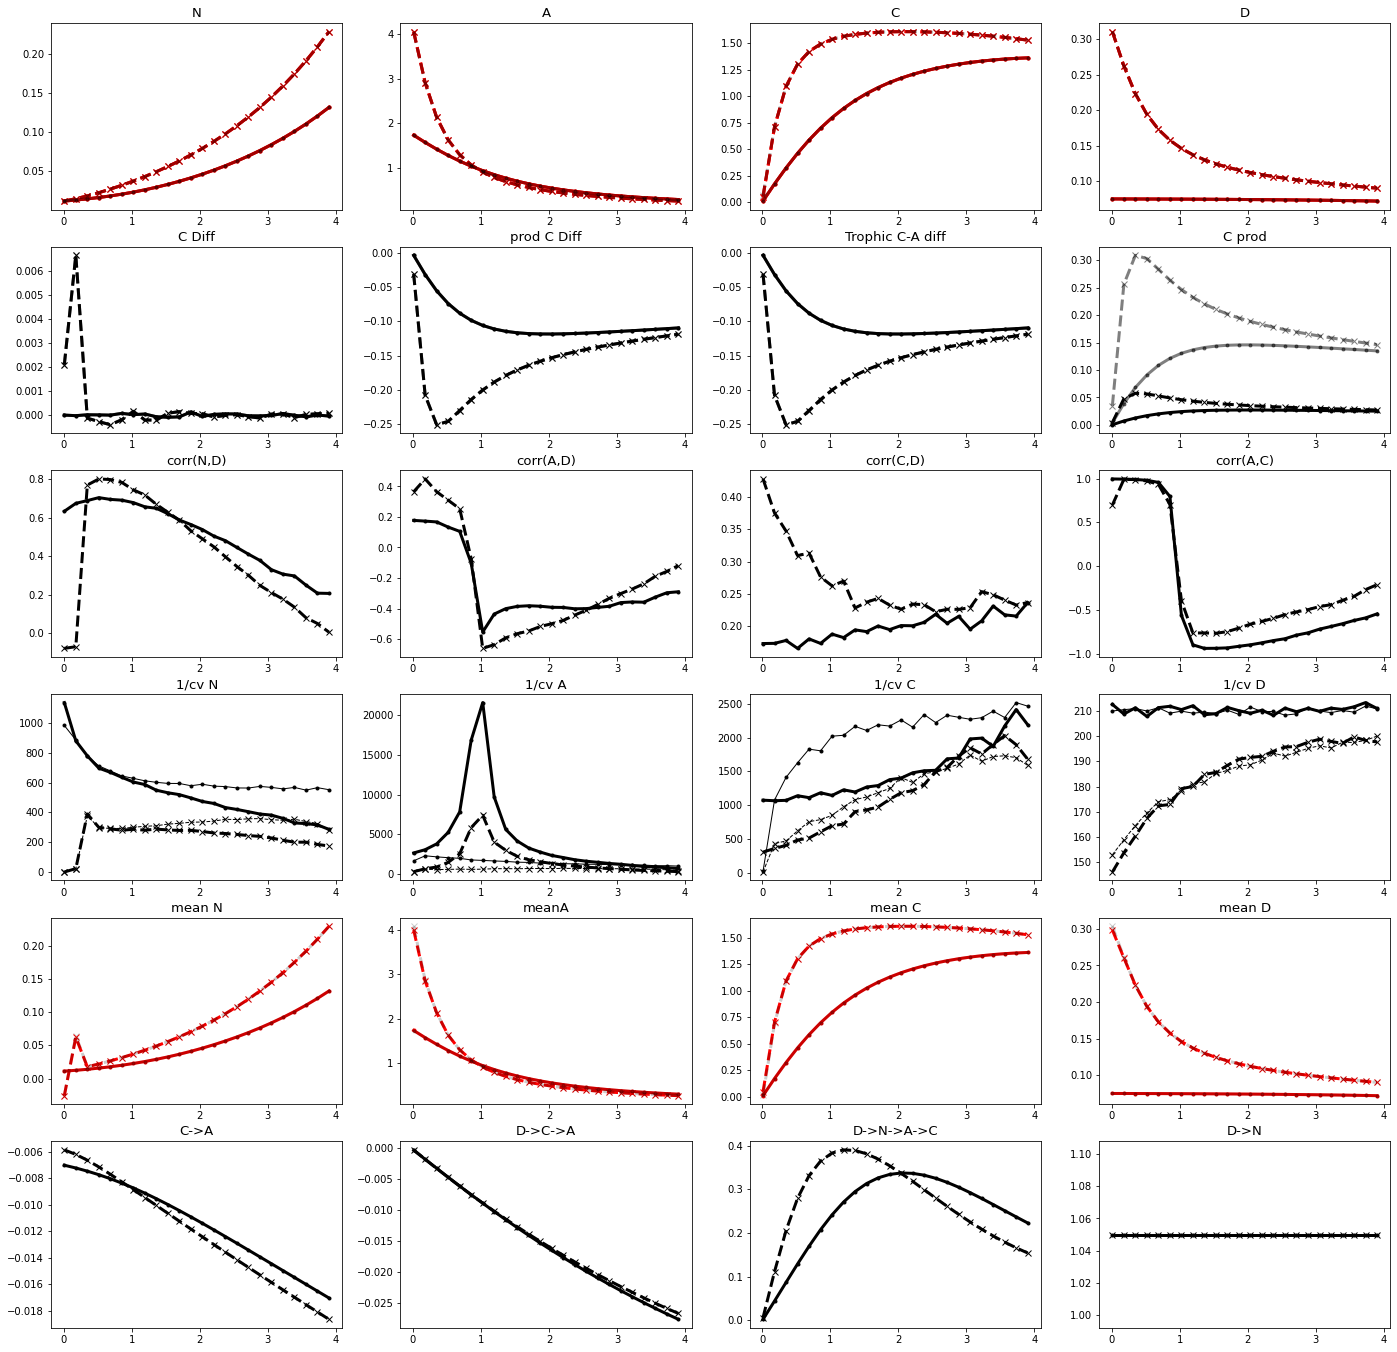

In [ ]:
%matplotlib inline
#####################
### PLOTS ###########
#####################
directory = './data/'
for l in range(len(pfiles['name'])):
    pr=setParams(fromFile=1,fnbr=l)
    with pd.option_context('display.width', 160,'display.max_rows', None,'display.max_columns', None,'display.precision', 3,):
                    display(pr)
    dfilen=''.join(['data',pfiles['name'][l]])
    varname=pd.read_csv(os.path.join(directory,dfilen))
    print(dfilen)
    print(l)
    pr.init.at[0]=1
    cmap=0   
    fCol=0
    resS=int(pr.resS[0])
    #toptitle=['delta=',delta,';r=',r,';Id=',IdOld,';ld=',ldOld,';ln=',ln,';In=',InOld,';lmdaa=',lmdaa,
    #          ';lmdac=',lmdacOld,';ma=',ma,';mc=',mc,';epsia=',epsia,';etac=',etac,';Iadj=',Iadj]
    nrows=2
    if pr.stoch[0]==1: nrows+=3
    if pr.jac[0]==1: nrows+=1
    
    fig, axes = plt.subplots(nrows,4,figsize=(24, 4*nrows))
    plt.rc('font', size=11)
    #fig.suptitle(''. join(str(e) for e in pr),fontsize=18)
    #plt.rcParams["figure.figsize"] = [36.00, 24.00]
    #plt.rcParams["figure.autolayout"] = True
    make_space_above(axes, topmargin=1.5)

    i=0
    for m in range(1):
        #n=1
        #varname=''.join(['data',pr['scenario'][m]])
        #varname=''.join(['data',pfiles['name'][n]])
        #varname='dataconsumerEng'
        #myvar=vars()
        #varname='data'

        #paramSpace(0,fCol,axes,myvar[varname]['eqCtrN'],myvar[varname]['eqCtrA'],myvar[varname]['eqCtrC'],myvar[varname]['eqCtrD'],resS,['N','A','C','D'],1,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
        #paramSpace(0,fCol,axes,myvar[varname]['eqAdjN'],myvar[varname]['eqAdjA'],myvar[varname]['eqAdjC'],myvar[varname]['eqAdjD'],resS,['N','A','C','D'],1,1,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks   

        #paramSpace(0,fCol,axes,myvar[varname]['xaxis'],myvar[varname]['minCtrN'],myvar[varname]['minCtrA'],myvar[varname]['minCtrC'],myvar[varname]['minCtrD'],resS,['N','A','C','D'],1,1,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks       
        #paramSpace(0,fCol,axes,myvar[varname]['xaxis'],myvar[varname]['maxCtrN'],myvar[varname]['maxCtrA'],myvar[varname]['maxCtrC'],myvar[varname]['maxCtrD'],resS,['N','A','C','D'],0.3,1,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks       
        #paramSpace(0,fCol,axes,myvar[varname]['xaxis'],myvar[varname]['minAdjN'],myvar[varname]['minAdjA'],myvar[varname]['minAdjC'],myvar[varname]['minAdjD'],resS,['N','A','C','D'],0.2,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks       
        #paramSpace(0,fCol,axes,myvar[varname]['xaxis'],myvar[varname]['maxAdjN'],myvar[varname]['maxAdjA'],myvar[varname]['maxAdjC'],myvar[varname]['maxAdjD'],resS,['N','A','C','D'],0.2,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks       

        #paramSpace(1,fCol,axes,myvar[varname]['xaxis'],myvar[varname]['Adiff'],myvar[varname]['Cdiff'],myvar[varname]['prodCtrA'],myvar[varname]['prodCtrC'],resS,['A diff','C diff','A prod','C prod'],1,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
        #paramSpace(1,fCol,axes,myvar[varname]['xaxis'],myvar[varname]['Adiff'],myvar[varname]['Cdiff'],myvar[varname]['prodAdjA'],myvar[varname]['prodAdjC'],resS,['A diff','C diff','A prod','C prod'],0.5,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks

        paramSpace(0,fCol,axes,varname['xaxis'],varname['minCtrN'],varname['minCtrA'],varname['minCtrC'],varname['minCtrD'],resS,['N','A','C','D'],1,3,lnbr=2,color=i+1) # stochastic adjusted vs non-adjusted stocks       
        paramSpace(0,fCol,axes,varname['xaxis'],varname['maxCtrN'],varname['maxCtrA'],varname['maxCtrC'],varname['maxCtrD'],resS,['N','A','C','D'],1,3,lnbr=2,color=i+1) # stochastic adjusted vs non-adjusted stocks       
        paramSpace(0,fCol,axes,varname['xaxis'],varname['minAdjN'],varname['minAdjA'],varname['minAdjC'],varname['minAdjD'],resS,['N','A','C','D'],0.2,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks       
        paramSpace(0,fCol,axes,varname['xaxis'],varname['maxAdjN'],varname['maxAdjA'],varname['maxAdjC'],varname['maxAdjD'],resS,['N','A','C','D'],0.2,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks       

        paramSpace(1,fCol,axes,varname['xaxis'],varname['eqCtrC']-varname['meanCtrC'],varname['prodCdiff'],varname['prodCdiff']-varname['prodAdiff'],varname['prodCtrC'],resS,['prod A Diff','prod C Diff','Trophic C-A diff','C prod'],1,3,lnbr=2,color=i) # adjusted vs non-adjusted stocks
        paramSpace(1,fCol,axes,varname['xaxis'],varname['eqCtrC']-varname['meanCtrC'],varname['prodCdiff'],varname['prodCdiff']-varname['prodAdiff'],varname['prodAdjC'],resS,['C Diff','prod C Diff','Trophic C-A diff','C prod'],0.5,3,lnbr=2,color=i) # adjusted vs non-adjusted stocks

        if pr.stoch[0]==1:
            #paramSpace(0,fCol,axes,myvar[varname]['meanCtrN'],myvar[varname]['meanCtrA'],myvar[varname]['meanCtrC'],myvar[varname]['meanCtrD'],resS,['N','A','C','D'],1,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
            #paramSpace(0,fCol,axes,myvar[varname]['meanAdjN'],myvar[varname]['meanAdjA'],myvar[varname]['meanAdjC'],myvar[varname]['meanAdjD'],resS,['N','A','C','D'],1,1,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
            paramSpace(2,fCol,axes,varname['xaxis'],varname['corrCtrND'],varname['corrCtrAD'],varname['corrCtrCD'],varname['corrCtrAC'],resS,['corr(N,D)','corr(A,D)','corr(C,D)','corr(A,C)'],1,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks 
            #paramSpace(2,fCol,axes,varname['xaxis'],varname['corrAdjND'],varname['corrAdjAD'],varname['corrAdjCD'],varname['corrAdjAC'],resS,['corr(N,D)','corr(A,D)','corr(C,D)','corr(A,C)'],1,1,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks    
            paramSpace(3,fCol,axes,varname['xaxis'],varname['cvCtrN'],varname['cvCtrA'],varname['cvCtrC'],varname['cvCtrD'],resS,['1/cv N','1/cv A','1/cv C','1/cv D'],1,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
            paramSpace(3,fCol,axes,varname['xaxis'],varname['cvAdjN'],varname['cvAdjA'],varname['cvAdjC'],varname['cvAdjD'],resS,['1/cv N','1/cv A','1/cv C','1/cv D'],1,1,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
            paramSpace(4,fCol,axes,varname['xaxis'],varname['meanCtrN'],varname['meanCtrA'],varname['meanCtrC'],varname['meanCtrD'],resS,['mean N','meanA','mean C','mean D'],1,3,lnbr=2,color=i+1) # stochastic adjusted vs non-adjusted stocks
            paramSpace(4,fCol,axes,varname['xaxis'],varname['meanAdjN'],varname['meanAdjA'],varname['meanAdjC'],varname['meanAdjD'],resS,['mean N','meanA','mean C','mean D'],0.2,3,lnbr=2,color=i) # stochastic adjusted vs non-adjusted stocks
        if pr.jac[0]==1:
            paramSpace(5,fCol,axes,varname['xaxis'],varname['j23'],varname['j34']*varname['j23'],varname['j14']*varname['j21']*varname['j32'],varname['j14'],resS,['C->A','D->C->A','D->N->A->C','D->N'],1,3,lnbr=2,color=i) # adjusted vs non-adjusted stocks
        
        #print(varname)
        i=i+1
    plt.show()

In [75]:
len(pfiles['name'])

1

In [ ]:
344.93+1069.27